## Download the Data

In [1]:
import os
import pandas as pd
import tarfile
import urllib.request

DOWNLOAD_URL = "https://github.com/fatimaezzahra-creator/Projet-ML/raw/refs/heads/main/datasets/adult.tgz"
DATASET_PATH = "datasets"

def fetch_data(data_url, data_path):
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    tgz_path = os.path.join(data_path, "adult.tgz")
    urllib.request.urlretrieve(data_url, tgz_path)
    tgz_file = tarfile.open(tgz_path)
    tgz_file.extractall(path=data_path)
    tgz_file.close()    

fetch_data(DOWNLOAD_URL, DATASET_PATH)

## A Look at the Data Structure

In [2]:
def load_data():
    csv_path = os.path.join(DATASET_PATH, "adult.data")
    return pd.read_csv(csv_path)

data = load_data()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1    workclass       32561 non-null  object
 2    fnlwgt          32561 non-null  int64 
 3    education       32561 non-null  object
 4    education-num   32561 non-null  int64 
 5    marital-status  32561 non-null  object
 6    occupation      32561 non-null  object
 7    relationship    32561 non-null  object
 8    race            32561 non-null  object
 9    sex             32561 non-null  object
 10   capital-gain    32561 non-null  int64 
 11   capital-loss    32561 non-null  int64 
 12   hours-per-week  32561 non-null  int64 
 13   native-country  32561 non-null  object
 14   class           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [3]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


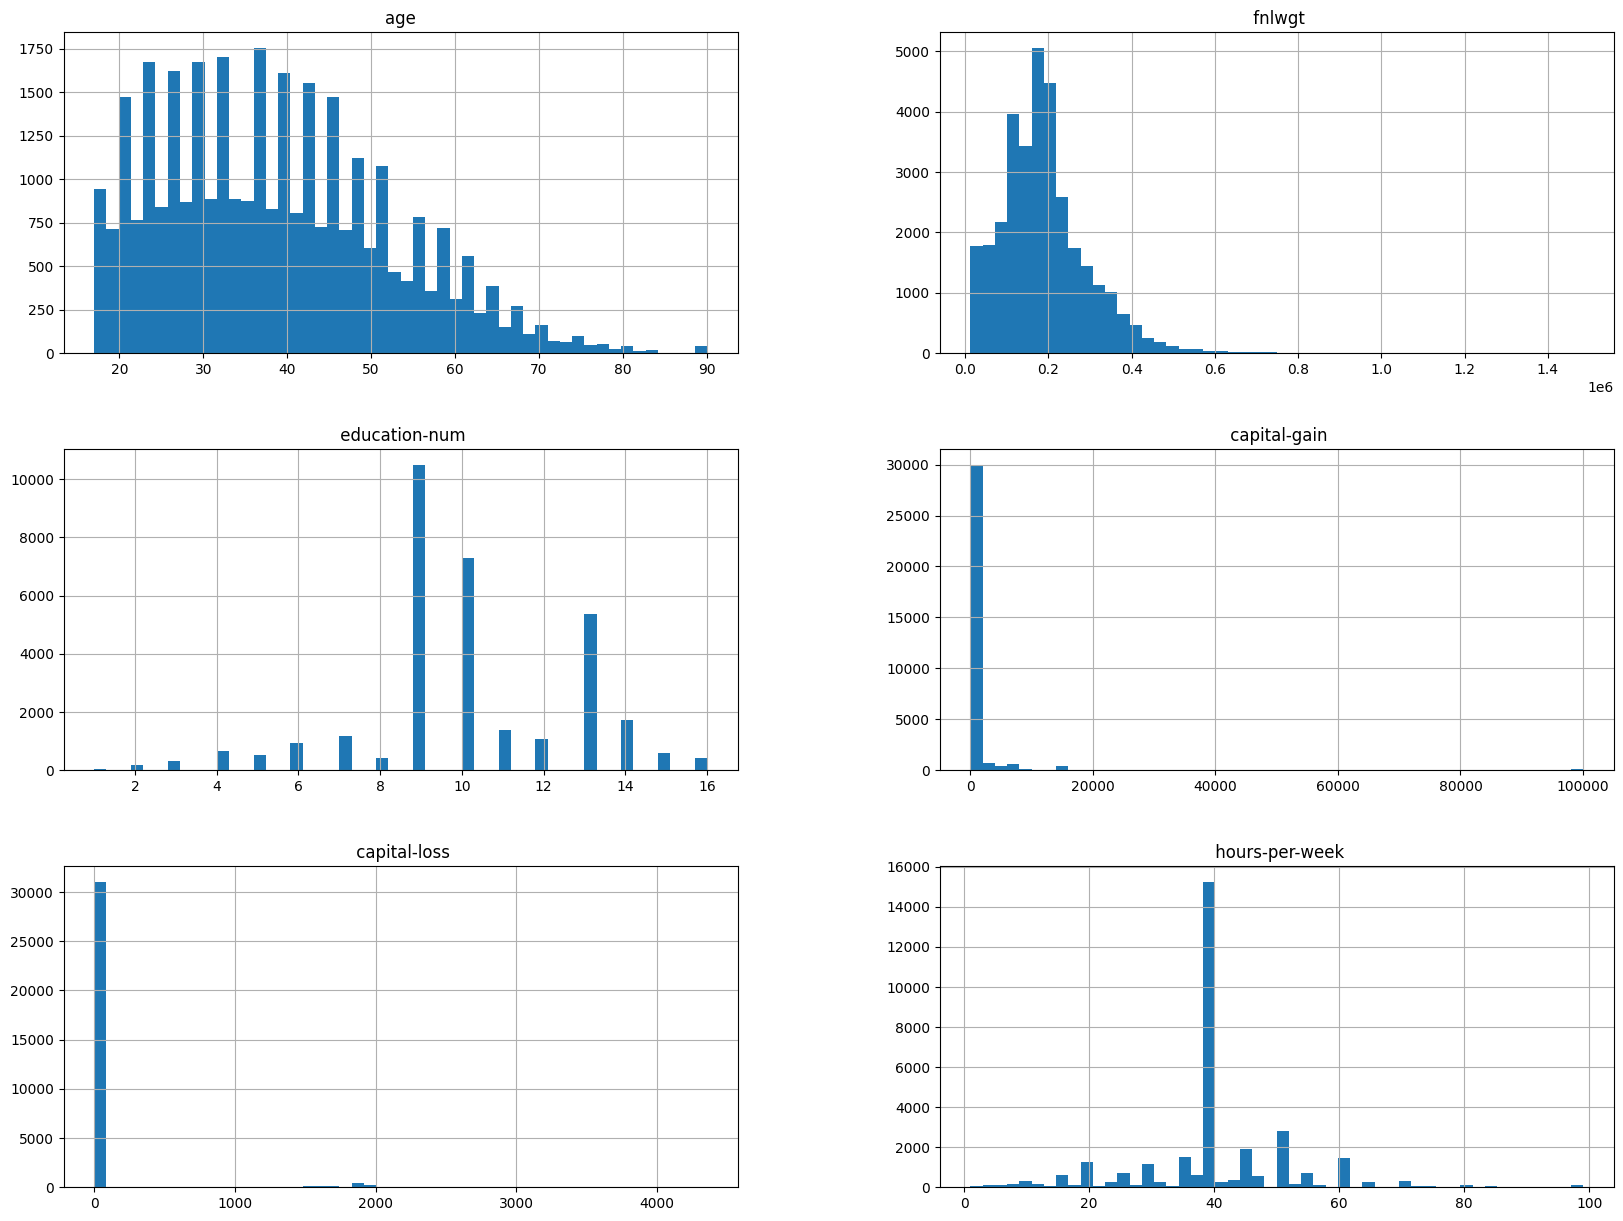

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()